In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sn 
import h5py

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras import regularizers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l1
import tensorflow as tf
from tensorflow.keras.losses import mse
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import decomposition

In [2]:
filename = '/home/bioml/Projects/PhD/InpactorDB/V2/InpactorDB_v2.fasta.kmers'
#filename = '/home/bioml/Projects/PhD/InpactorDB/V2/InpactorDB_v2.fasta.complementary'
training = pd.read_csv(filename)
training

,Label,A,C,G,T,AA,AC,AG,AT,CA,...,TTTTCG,TTTTCT,TTTTGA,TTTTGC,TTTTGG,TTTTGT,TTTTTA,TTTTTC,TTTTTG,TTTTTT
0,20,1578,1556,1674,2221,392,288,467,397,319,...,4,6,9,2,4,10,6,11,11,8
1,3,2621,1141,980,2526,944,309,340,828,445,...,0,5,5,4,0,3,1,5,1,1
2,3,2634,1230,1051,2501,983,363,374,777,432,...,2,10,0,3,2,4,3,2,2,2
3,3,2559,1004,1156,2676,897,281,406,836,382,...,2,4,7,1,7,1,7,9,4,12
4,3,2653,1182,1463,2823,948,359,461,873,425,...,5,5,10,2,8,5,17,7,8,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46929,12,1141,632,864,1223,320,152,314,355,239,...,1,2,3,1,1,3,2,1,0,7
46930,16,1224,918,1175,1102,347,222,387,262,242,...,1,5,2,1,2,3,1,2,1,0
46931,12,1391,1124,695,1234,478,304,249,351,451,...,0,1,1,0,1,1,4,2,1,4
46932,9,1126,580,757,1038,355,116,318,315,245,...,2,2,2,3,1,1,1,1,2,4


In [3]:
Y = training['Label'].values
X = training.drop(['Label'], axis=1).values

In [4]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaler = scaler.transform(X)

In [5]:
def get_model(input_dim, code_size, beta=.01):
    inputs = Input(shape=input_dim)
    layers = Dense(4000, activation='relu')(inputs)
    layers = Dense(3500, activation='relu')(layers)
    layers = Dense(2048, activation='relu')(layers)
    layers = Dense(1024, activation='relu')(layers)
    encoder = Dense(256, activation='relu', name="encoder")(layers)
    #encoder = Dense(128, activation='relu', name="encoder")(layers)
    #layers = Dense(256, activation='relu')(encoder)
    layers = Dense(1024, activation='relu')(encoder)
    layers = Dense(2048, activation='relu')(layers)
    layers = Dense(3500, activation='relu')(layers)
    layers = Dense(4000, activation='relu')(layers)
    outputs = Dense(input_dim, activation='sigmoid')(layers)

    avg_latent_activations = tf.reduce_mean(encoder, axis=0)
    #loss = tf.reduce_mean((inputs - outputs)**2) + beta * tf.reduce_mean(encoder)
    loss = tf.reduce_mean( (inputs-outputs)**2)

    model = Model([inputs], [outputs])    
    model.add_loss(loss)

    model.compile(optimizer='adam')
    return model, encoder, avg_latent_activations

In [6]:
model, encoder, avg_latent_activations = get_model(input_dim=X_scaler.shape[1], code_size=64, beta=0.05)

In [8]:
history = model.fit(X_scaler, epochs=200, batch_size=64)

Epoch 1/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6832
Epoch 2/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6815
Epoch 3/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6814
Epoch 4/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6791
Epoch 5/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6779
Epoch 6/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6768
Epoch 7/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6754
Epoch 8/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6752
Epoch 9/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6736
Epoch 10/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6724
Epoch 11/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6722
Epoch 12/200
734/734 [==============================] - 10s 14ms/step - lo

734/734 [==============================] - 10s 14ms/step - loss: 0.6405
Epoch 193/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6409
Epoch 194/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6425
Epoch 195/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6398
Epoch 196/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6419
Epoch 197/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6407
Epoch 198/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6394
Epoch 199/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6400
Epoch 200/200
734/734 [==============================] - 10s 14ms/step - loss: 0.6408


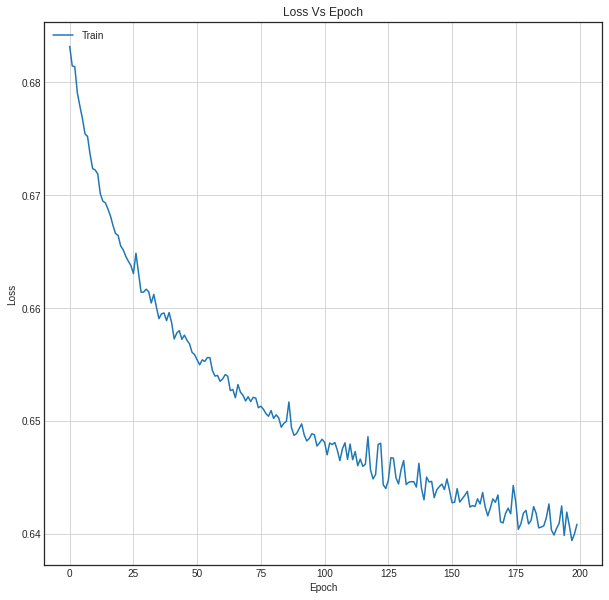

In [10]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['loss'])
    plt.title('Loss Vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 

In [11]:
#save the trained model
model.save_weights('autoencoders_network.h5')

In [5]:
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(X_scaler, Y, test_size=validation_size, random_state=seed)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

encoder = Model(model.input, model.get_layer('encoder').output)
X_train_encoder = encoder.predict(X_trainScaler)  # bottleneck representation
X_dev_encoder = encoder.predict(X_dev) 
X_test_encoder = encoder.predict(X_test) 

NameError: name 'model' is not defined

In [13]:
#defining a classifier
def Nakano_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_train_encoder.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(200,activation="relu")(inputs)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    # layer 4
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model

In [14]:
classifier = Nakano_Net()
one_hot_labels_train = tf.keras.utils.to_categorical(Y_trainScaler, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

history=classifier.fit(X_train_encoder, one_hot_labels_train, epochs=200, 
                      batch_size=128,validation_data=(X_dev_encoder, one_hot_labels_validation),verbose=1)

Epoch 1/200
294/294 [==============================] - 1s 2ms/step - loss: 1.4654 - accuracy: 0.6336 - val_loss: 0.5861 - val_accuracy: 0.8236
Epoch 2/200
294/294 [==============================] - 1s 2ms/step - loss: 0.7228 - accuracy: 0.7663 - val_loss: 0.4826 - val_accuracy: 0.8464
Epoch 3/200
294/294 [==============================] - 1s 2ms/step - loss: 0.6073 - accuracy: 0.8037 - val_loss: 0.4294 - val_accuracy: 0.8638
Epoch 4/200
294/294 [==============================] - 1s 2ms/step - loss: 0.5420 - accuracy: 0.8265 - val_loss: 0.3995 - val_accuracy: 0.8717
Epoch 5/200
294/294 [==============================] - 1s 2ms/step - loss: 0.4983 - accuracy: 0.8389 - val_loss: 0.3778 - val_accuracy: 0.8796
Epoch 6/200
294/294 [==============================] - 1s 2ms/step - loss: 0.4681 - accuracy: 0.8468 - val_loss: 0.3568 - val_accuracy: 0.8851
Epoch 7/200
294/294 [==============================] - 1s 2ms/step - loss: 0.4443 - accuracy: 0.8545 - val_loss: 0.3493 - val_accuracy: 0.8873

Epoch 58/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2435 - accuracy: 0.9173 - val_loss: 0.2440 - val_accuracy: 0.9258
Epoch 59/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2411 - accuracy: 0.9176 - val_loss: 0.2433 - val_accuracy: 0.9246
Epoch 60/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2431 - accuracy: 0.9180 - val_loss: 0.2450 - val_accuracy: 0.9276
Epoch 61/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2444 - accuracy: 0.9168 - val_loss: 0.2379 - val_accuracy: 0.9286
Epoch 62/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2421 - accuracy: 0.9195 - val_loss: 0.2420 - val_accuracy: 0.9250
Epoch 63/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2362 - accuracy: 0.9215 - val_loss: 0.2389 - val_accuracy: 0.9276
Epoch 64/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2370 - accuracy: 0.9183 - val_loss: 0.2450 - val_accuracy:

Epoch 115/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2156 - accuracy: 0.9261 - val_loss: 0.2527 - val_accuracy: 0.9286
Epoch 116/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2110 - accuracy: 0.9272 - val_loss: 0.2545 - val_accuracy: 0.9267
Epoch 117/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2126 - accuracy: 0.9276 - val_loss: 0.2444 - val_accuracy: 0.9333
Epoch 118/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2089 - accuracy: 0.9296 - val_loss: 0.2486 - val_accuracy: 0.9305
Epoch 119/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2095 - accuracy: 0.9275 - val_loss: 0.2491 - val_accuracy: 0.9325
Epoch 120/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2091 - accuracy: 0.9299 - val_loss: 0.2503 - val_accuracy: 0.9297
Epoch 121/200
294/294 [==============================] - 1s 2ms/step - loss: 0.2136 - accuracy: 0.9256 - val_loss: 0.2542 - val_ac

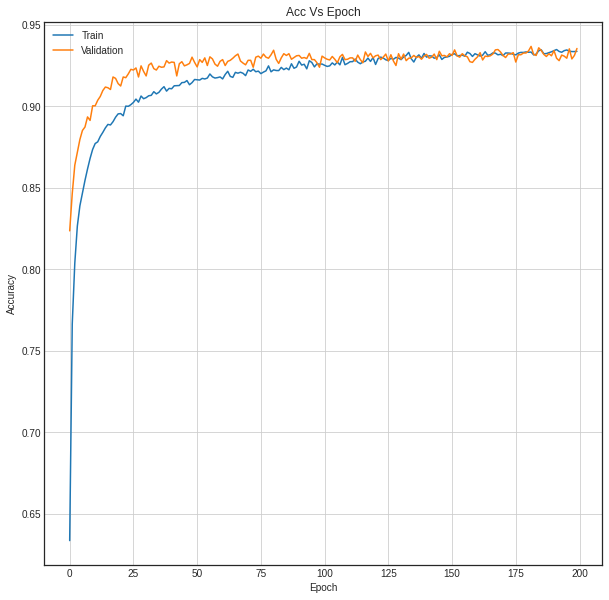

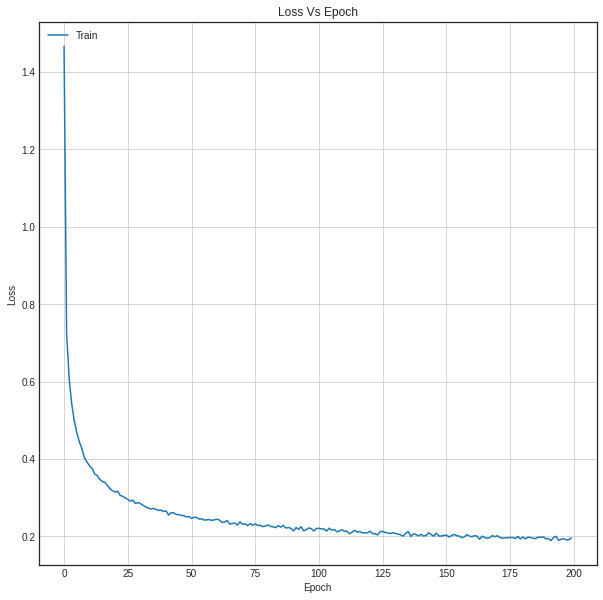

In [15]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['accuracy'])
    plt.plot([x for x in range(200)], history.history['val_accuracy'])
    plt.title('Acc Vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 
    
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['loss'])
    plt.title('Loss Vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 

In [16]:
#comparing with PCA
pca = decomposition.PCA(n_components=256,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

In [17]:
classifier = Nakano_Net()

history=classifier.fit(X_trainPCAScaler, one_hot_labels_train, epochs=200, 
                      batch_size=128,validation_data=(X_validationPCAScaler, one_hot_labels_validation),verbose=1)

Epoch 1/200
294/294 [==============================] - 1s 2ms/step - loss: 0.6047 - accuracy: 0.8134 - val_loss: 0.1581 - val_accuracy: 0.9518
Epoch 2/200
294/294 [==============================] - 1s 2ms/step - loss: 0.1891 - accuracy: 0.9404 - val_loss: 0.1035 - val_accuracy: 0.9727
Epoch 3/200
294/294 [==============================] - 1s 2ms/step - loss: 0.1252 - accuracy: 0.9613 - val_loss: 0.1003 - val_accuracy: 0.9700
Epoch 4/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0974 - accuracy: 0.9698 - val_loss: 0.0914 - val_accuracy: 0.9746
Epoch 5/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0761 - accuracy: 0.9762 - val_loss: 0.0797 - val_accuracy: 0.9774
Epoch 6/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0635 - accuracy: 0.9787 - val_loss: 0.0780 - val_accuracy: 0.9808
Epoch 7/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0548 - accuracy: 0.9823 - val_loss: 0.0876 - val_accuracy: 0.9770

Epoch 58/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0109 - accuracy: 0.9970 - val_loss: 0.1500 - val_accuracy: 0.9793
Epoch 59/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0158 - accuracy: 0.9963 - val_loss: 0.1207 - val_accuracy: 0.9795
Epoch 60/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.1421 - val_accuracy: 0.9791
Epoch 61/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 0.1288 - val_accuracy: 0.9798
Epoch 62/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0115 - accuracy: 0.9967 - val_loss: 0.1403 - val_accuracy: 0.9810
Epoch 63/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.1331 - val_accuracy: 0.9789
Epoch 64/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0140 - accuracy: 0.9964 - val_loss: 0.1591 - val_accuracy:

Epoch 115/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.1863 - val_accuracy: 0.9789
Epoch 116/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0076 - accuracy: 0.9982 - val_loss: 0.2103 - val_accuracy: 0.9781
Epoch 117/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.2061 - val_accuracy: 0.9795
Epoch 118/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.2107 - val_accuracy: 0.9789
Epoch 119/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0069 - accuracy: 0.9982 - val_loss: 0.2473 - val_accuracy: 0.9781
Epoch 120/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.2020 - val_accuracy: 0.9783
Epoch 121/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0142 - accuracy: 0.9972 - val_loss: 0.1985 - val_ac

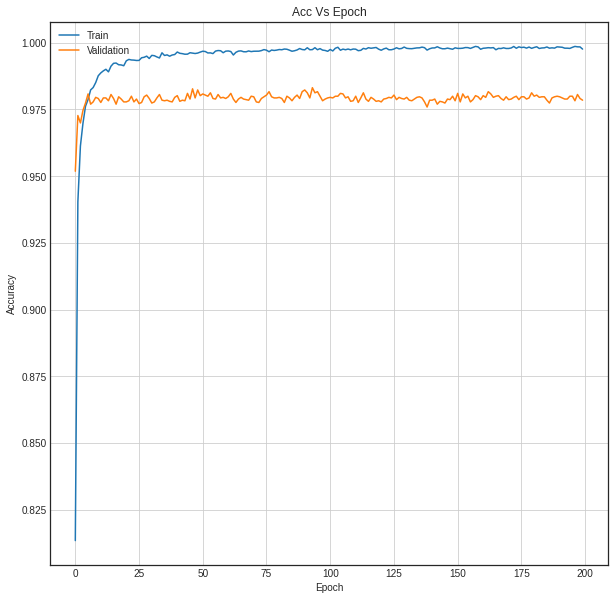

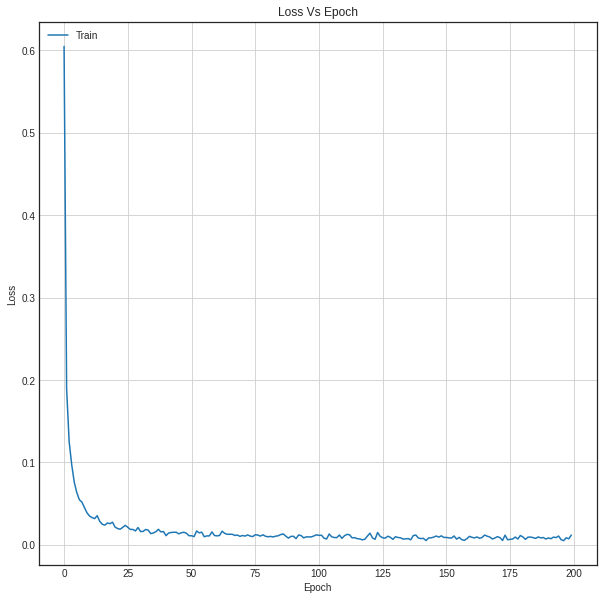

In [18]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['accuracy'])
    plt.plot([x for x in range(200)], history.history['val_accuracy'])
    plt.title('Acc Vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 
    
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['loss'])
    plt.title('Loss Vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 

In [19]:
print(X_trainPCAScaler.shape)

(37547, 256)


In [20]:
print(X_train_encoder.shape)

(37547, 256)


In [15]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X_trainScaler.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='multiclass', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [16]:
# Fit the model
    
# Train using early stopping
model.fit(X_trainScaler, Y_trainScaler, early_stopping_rounds=100, eval_set = [(X_dev, Y_dev)], eval_metric = 'multi_logloss', verbose = 1)

# Record the feature importances
feature_importances += model.feature_importances_

[1]	valid_0's multi_logloss: 2.20575
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.97055
[3]	valid_0's multi_logloss: 1.78729
[4]	valid_0's multi_logloss: 1.6429
[5]	valid_0's multi_logloss: 1.5191
[6]	valid_0's multi_logloss: 1.41051
[7]	valid_0's multi_logloss: 1.31904
[8]	valid_0's multi_logloss: 1.23702
[9]	valid_0's multi_logloss: 1.16321
[10]	valid_0's multi_logloss: 1.09853
[11]	valid_0's multi_logloss: 1.04231
[12]	valid_0's multi_logloss: 0.990491
[13]	valid_0's multi_logloss: 0.94283
[14]	valid_0's multi_logloss: 0.899088
[15]	valid_0's multi_logloss: 0.858577
[16]	valid_0's multi_logloss: 0.820872
[17]	valid_0's multi_logloss: 0.786162
[18]	valid_0's multi_logloss: 0.752306
[19]	valid_0's multi_logloss: 0.7222
[20]	valid_0's multi_logloss: 0.693736
[21]	valid_0's multi_logloss: 0.667048
[22]	valid_0's multi_logloss: 0.64097
[23]	valid_0's multi_logloss: 0.617707
[24]	valid_0's multi_logloss: 0.595573
[25]	valid_0's multi_logloss

[208]	valid_0's multi_logloss: 0.122523
[209]	valid_0's multi_logloss: 0.12254
[210]	valid_0's multi_logloss: 0.12259
[211]	valid_0's multi_logloss: 0.122362
[212]	valid_0's multi_logloss: 0.122203
[213]	valid_0's multi_logloss: 0.122277
[214]	valid_0's multi_logloss: 0.122261
[215]	valid_0's multi_logloss: 0.122024
[216]	valid_0's multi_logloss: 0.122111
[217]	valid_0's multi_logloss: 0.122043
[218]	valid_0's multi_logloss: 0.121802
[219]	valid_0's multi_logloss: 0.121921
[220]	valid_0's multi_logloss: 0.122072
[221]	valid_0's multi_logloss: 0.121907
[222]	valid_0's multi_logloss: 0.121976
[223]	valid_0's multi_logloss: 0.121942
[224]	valid_0's multi_logloss: 0.121821
[225]	valid_0's multi_logloss: 0.121773
[226]	valid_0's multi_logloss: 0.121836
[227]	valid_0's multi_logloss: 0.121817
[228]	valid_0's multi_logloss: 0.12197
[229]	valid_0's multi_logloss: 0.121855
[230]	valid_0's multi_logloss: 0.121709
[231]	valid_0's multi_logloss: 0.121557
[232]	valid_0's multi_logloss: 0.121625
[23

In [17]:
model.score(X_test, Y_test)

0.9627183638687686

In [18]:
print(training.drop(['Label'], axis=1).columns)

print(len(feature_importances))

Index(['A', 'C', 'G', 'T', 'AA', 'AC', 'AG', 'AT', 'CA', 'CC',
       ...
       'TTTTCG', 'TTTTCT', 'TTTTGA', 'TTTTGC', 'TTTTGG', 'TTTTGT', 'TTTTTA',
       'TTTTTC', 'TTTTTG', 'TTTTTT'],
      dtype='object', length=5460)
5460


In [19]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(training.drop(['Label'], axis=1).columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

In [25]:
print(feature_importances)
type(feature_importances)

     feature  importance
3          T       157.5
0          A       146.5
123     AGCT       127.5
2731  CCCCCT       101.0
2046  AGGGGG       100.0
...      ...         ...
2493  CACGGC         0.0
3138  CGTGTG         0.0
2949  CGATAC         0.0
3853  GCGTGC         0.0
1775  ACGCGT         0.0

[5460 rows x 2 columns]


pandas.core.frame.DataFrame

T 157.5
A 146.5
AGCT 127.5
CCCCCT 101.0
AGGGGG 100.0
ACATA 99.5
ATAT 93.5
TATGT 91.5
AAAAAA 85.5
C 81.0
CATC 77.0
CCAT 76.0
TATAT 75.0
GATC 73.0
CTTC 71.5
GAA 71.5
ACAT 71.0
TTAA 70.5
G 70.0
GATGA 69.5
ATGT 69.0
AAGG 69.0
CCTT 68.0
CTTG 68.0
AAGC 67.0
AAG 66.5
CTAG 65.5
TCT 65.5
CTT 64.0
GGCC 63.5
ATATA 63.5
GCT 63.0
TTTTTT 61.5
CCAAT 60.0
TGCC 60.0
CCGG 59.5
GGGGGA 58.5
TTC 58.0
ATTAAT 57.5
CCA 57.0
GATG 57.0
GCC 56.5
GC 56.0
TAAC 56.0
GGGGAG 55.5
AT 55.5
TTGGC 54.5
AGA 54.5
GAAG 54.0
TGG 54.0
CAAG 54.0
CATGT 53.5
CTTT 52.0
TC 51.5
GTAC 51.0
GGG 51.0
GA 51.0
GGC 50.5
TACC 50.5
TTAAT 50.5
CAGT 50.0
ATC 49.5
GTA 49.0
TTGC 49.0
TCTG 49.0
TCAA 49.0
AAAG 48.5
TCATC 48.5
TATG 47.5
AGTT 47.5
GTTATG 47.0
GATATG 47.0
TGTA 47.0
CATTAA 47.0
GTTA 46.5
ACGT 46.5
AGC 46.0
AACTC 45.0
TATA 45.0
ATGTAT 44.5
AATTG 44.5
TGGGG 44.0
GAGTT 43.5
ACTT 43.5
ATCA 43.5
TAC 43.5
TTCTT 43.0
CTCT 43.0
CTTTT 43.0
ATGG 42.5
TGCA 42.0
GAAT 42.0
GCTTG 42.0
TTATG 42.0
TA 42.0
AACT 42.0
GATAT 41.5
GAT 41.5
AAGCA 41.0
CT

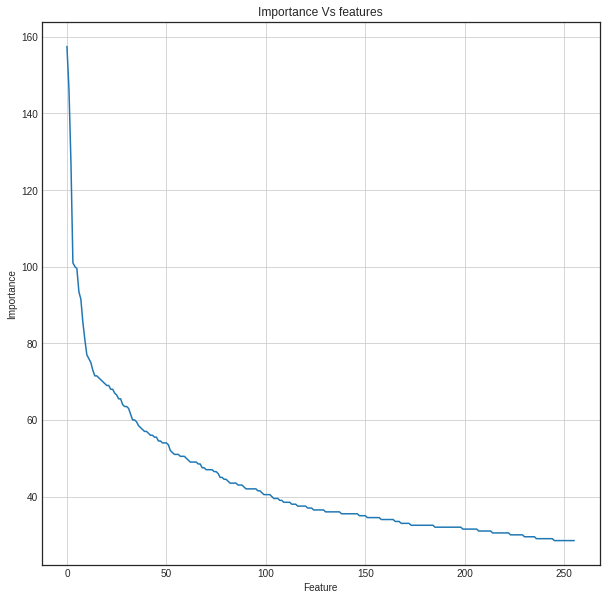

In [26]:
i = 0
importances = []
features = []
for imp in feature_importances['importance']:
    if imp > 0:
        print(list(feature_importances['feature'])[i]+" "+str(imp))
        importances.append(imp)
        features.append(list(feature_importances['feature'])[i])
    i += 1
    if len(importances) == 256:
        break
    
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(len(importances))], importances)
    plt.title('Importance Vs features')
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 